In [1]:
!pip install folium --quiet
!pip install pymongo

In [3]:
import pandas as pd
from pymongo import MongoClient

%matplotlib inline

mongo_client = MongoClient('this_mongo')
database_reference = mongo_client.twitter

In [4]:
tweet_collection = database_reference.tweets
cursor_sampl = tweet_collection.aggregate([{'$sample': {'size': 10000}}])

| | | | | |
|-|-|-|-|-|
| `_id`        | `truncated`                 |`user`            |`extended_tweet` | `favorited`                   |
| `created_at` | `in_reply_to_status_id`     |`geo`             |`quote_count`    | `retweeted`                   |
| `id`         | `in_reply_to_status_id_str` |`coordinates`     |`reply_count`    | `filter_level`                |
| `id_str`     | `in_reply_to_user_id`       |`place`           |`retweet_count`  | `lang`                        |
| `text`       | `in_reply_to_user_id_str`   |`contributors`    |`favorite_count` | `timestamp_ms`                |
| `source`     | `in_reply_to_screen_name`   |`is_quote_status` |`entities`       |                               |
























![](https://www.evernote.com/l/AAEO7gpKcKdI5YJeGrni4GhdlBiBWdTa3YgB/image.png)

In [5]:
sample_group = list(cursor_sampl)

In [6]:
database_reference.vineland_test_group.insert_many(sample_group)

BulkWriteError: batch op errors occurred

In [7]:
database_reference.vineland_test_group.count()

10015

## Tweets By Day

In [8]:
date_from_string = {"$dateFromString" : { "dateString" : "$created_at"}}

date_to_id = {
    "$project": {
        "_id" : 0,
        "year" : {"$year": {"date" : date_from_string}},
        "month" : {"$month": {"date" : date_from_string}},
        "day" : {"$dayOfMonth": {"date" : date_from_string}},
    }
}

group_by_date = {
    "$group" : {
        "tweets" : {"$sum" : 1},
        "_id" : {
            "year" : "$year",
            "month" : "$month",
            "day" : "$day"
        },
    }
}



In [9]:
def dictionary_to_datestring(x):
    year = x['year']
    month = x['month']
    day = x['day']
    return "{}-{}-{}".format(month, day, year)

In [23]:
cursor = database_reference.vineland_test_group.aggregate([
    date_to_id,
    group_by_date
])

daily_tweets = pd.DataFrame(list(cursor))

In [24]:
daily_tweets

,_id,tweets
0,"{'year': None, 'month': None, 'day': None}",1
1,"{'year': 2018, 'month': 2, 'day': 3}",55
2,"{'year': 2018, 'month': 2, 'day': 13}",555
3,"{'year': 2018, 'month': 2, 'day': 15}",199
4,"{'year': 2018, 'month': 2, 'day': 7}",1034
5,"{'year': 2018, 'month': 2, 'day': 9}",616
6,"{'year': 2018, 'month': 2, 'day': 4}",1567
7,"{'year': 2018, 'month': 2, 'day': 12}",550
8,"{'year': 2018, 'month': 2, 'day': 10}",535
9,"{'year': 2018, 'month': 2, 'day': 14}",667


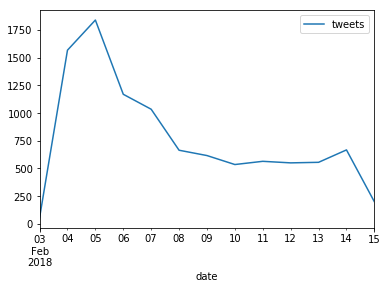

In [25]:
daily_tweets.drop(0,inplace=True)
datestrings = daily_tweets['_id'].apply(dictionary_to_datestring)
daily_tweets['date'] = pd.to_datetime(datestrings)

daily_tweets.drop('_id', axis=1, inplace=True)
daily_tweets.sort_values('date', inplace=True)
daily_tweets.set_index('date', inplace=True)
daily_tweets.plot()

In [12]:
datestrings

0     None-None-None
1           2-3-2018
2          2-13-2018
3          2-15-2018
4           2-7-2018
5           2-9-2018
6           2-4-2018
7          2-12-2018
8          2-10-2018
9          2-14-2018
10          2-5-2018
11         2-11-2018
12          2-8-2018
13          2-6-2018
Name: _id, dtype: object

In [35]:
daily_tweets

,_id,tweets
1,"{'year': 2018, 'month': 2, 'day': 3}",55
2,"{'year': 2018, 'month': 2, 'day': 13}",555
3,"{'year': 2018, 'month': 2, 'day': 15}",198
4,"{'year': 2018, 'month': 2, 'day': 7}",1033
5,"{'year': 2018, 'month': 2, 'day': 9}",616
6,"{'year': 2018, 'month': 2, 'day': 4}",1566
7,"{'year': 2018, 'month': 2, 'day': 12}",547
8,"{'year': 2018, 'month': 2, 'day': 10}",535
9,"{'year': 2018, 'month': 2, 'day': 14}",667
10,"{'year': 2018, 'month': 2, 'day': 5}",1837


## Tweet Locations

In [7]:
nonnull_geo = {'geo' : {'$ne' : None}}
just_geo = {'geo' : 1}

cursor = database_reference.vineland_test_group.find(nonnull_geo, just_geo)
cursor.count()

984

In [8]:
geo_tweets = pd.DataFrame(list(cursor))

In [9]:
def parse_geo_from_tweets(tweets):
    geo = pd.DataFrame(list(tweets['geo'].values))
    return geo

In [10]:
geo = parse_geo_from_tweets(geo_tweets)
geo.sample(5)

,coordinates,type
498,"[39.6697, -79.4147]",Point
280,"[40.0, -74.5]",Point
539,"[39.76428, -75.53112]",Point
508,"[39.4863773, -75.0259637]",Point
709,"[37.1379265, -76.8352384]",Point


In [11]:
import folium
starting_loc = [34.0689, -118.4452]
la_map = folium.Map(location=starting_loc, zoom_start=13)

In [12]:
for loc in geo.coordinates.values:
    folium.Marker(loc).add_to(la_map)

In [13]:
la_map